# Auto-Trading Agent with Deep Q Networks
This week I have been experimenting with deep Q networks - specifically with the goal of designing and training an agent that can 'trade' and make a profit from a resource with a fluctuating value. My aim was to produce something that was highly generalised, which lead me away from supervised techniques.

In [0]:
import tensorflow as tf
model = tf.keras.models.load_model("models/1-model.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 4)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 4)         20          input_1[0][0]                    
__________________________________________________________________________________________________
attention_probs (Dense)         (None, 1, 4)         20          dense[0][0]                      
__________________________________________________________________________________________________
multiply (Multiply)             (None, 1, 4)         0           dense[0][0]                      
                                                                 attention_probs[0][0]        

## The Model
The prototype model above shows the basic premise:

### Input shape (x = Batch size, y = 1, z = 4) 
The z dimension (4) is the number of past values the model will look at.
The y dimension is extensible for extra resource types. For simplicity this model only has one.

### Dense layer, Attention_Probs, Multiply
This is the first hidden layer of the network and it is a rudimentary approximation of an attentions layer. 

### Output layer (x = Batch size, y = 1, z = 3) 
The output layer gives us the Q values for our 3 actions: Buy, Sell, Hold.

## The Training Environment

In [0]:
class TradeEnv:
    def __init__(self, VALUE=5, EPISODE_LENGTH=16, OBS_LENGTH=4, loud=False):
        self.VALUE = VALUE
        self.EPISODE_LENGTH = EPISODE_LENGTH
        self.OBS_LENGTH = OBS_LENGTH
        self.loud = loud

    ACTION_SPACE_SIZE = 3

    def reset(self):
        self.player = Trader()
        self.currVal = self.VALUE
        self.episode_step = 0

        self.observations = np.ones(shape=(1, self.OBS_LENGTH)) * self.currVal
        return self.observations

    def step(self, action):
        self.episode_step += 1
        self.player.action(action, self.currVal)

        self.currVal = self.nextVal()
        #if self.loud: print("%.2f" % self.currVal)

        self.observations = np.insert(self.observations, self.observations.size, self.currVal, 1)
        self.observations = np.delete(self.observations, 0, axis=1)

        done = False
        if self.check_done():
            done = True

        return self.observations, self.calculate_reward(), done

    def calculate_reward(self):
        return self.player.cash + (self.player.units * self.currVal)

    def check_done(self):
        return self.episode_step > self.EPISODE_LENGTH or self.player.broke(self.currVal)

    def nextVal(self):
        return abs(self.currVal+np.random.randn())

In [0]:
class Trader:
    def __init__(self):
        self.cash = 10
        self.units = 0
        self.decay_value = 0.95

    def __str__(self):
        return f"{self.cash}, {self.units}"

    def action(self, choice, currVal):
        if choice == 0:
            #buy
            self.trade(currVal, 1)
        elif choice == 1:
            #sell
            self.trade(currVal, -1)
        elif choice == 2:
            #hold
            self.trade(currVal, 0)
        
        #decay to encourage the agent to act
        self.cash = self.cash * self.decay_value
        self.units = self.units * self.decay_value
        #if loud: print("%d: %.2f %.2f" % (choice, self.cash, self.units))

    def trade(self, currVal, direction):
        if direction == 1: #buy
            if self.cash > 0:
                try:
                    units_gained, cash_left = divmod(self.cash, currVal) #get quotient, remainder
                except ZeroDivisionError as error:
                    print(self.cash, " ", currVal)
                    raise
                self.units += units_gained
                self.cash = cash_left

        elif direction == -1: #sell
            if self.units > 0:
                cash_gained = self.units * currVal
                self.cash += cash_gained
                self.units = 0

    def broke(self, currVal):
        return (self.cash < currVal) & (self.units == 0)

### ```VALUE = 5```
The value of the resource starts at 5 and varies by numpy.random.randn() each step.
### ```self.observations```
Observations is the array of past values that is fed into the model.
### ```def calculate_reward(self):```
The reward function returns the total cash the agent still has and the total value of their owned units. Originally this only returned the remaining cash value but I believed that this penalised the model from investing.

## The Agent

In [0]:
# code adapted from https://pythonprogramming.net/deep-q-learning-dqn-reinforcement-learning-python-tutorial/

class DQNAgent:
    def __init__(self, MODEL_NAME, MODEL_LOAD_PATH="", OBS_LENGTH=4, MINIBATCH_SIZE=1,
                    REPLAY_MEMORY_SIZE=50000, MIN_REPLAY_MEMORY_SIZE=4, DISCOUNT=0.999,
                    UPDATE_TARGET_EVERY=5):

        self.MODEL_NAME = MODEL_NAME
        self.OBS_LENGTH = OBS_LENGTH
        self.MINIBATCH_SIZE = MINIBATCH_SIZE
        self.MIN_REPLAY_MEMORY_SIZE = MIN_REPLAY_MEMORY_SIZE
        self.DISCOUNT = DISCOUNT
        self.UPDATE_TARGET_EVERY = UPDATE_TARGET_EVERY
        
        # Main model
        if MODEL_LOAD_PATH == "":
            self.model = self.create_model()
        else:
            self.model = tf.keras.models.load_model(MODEL_LOAD_PATH)

        # Target network
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # An array with last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0

    def create_model(self):
        
        inputs = Input(shape=(1, self.OBS_LENGTH, ))
        rnn_out = Dense(self.OBS_LENGTH)(inputs)
        attention_probs = Dense(self.OBS_LENGTH, activation='sigmoid', name='attention_probs')(rnn_out)
        attention_mul = multiply([ rnn_out, attention_probs ])
        output = Dense(3, activation='softmax', name='output')(attention_mul)

        m = Model(inputs=[inputs], outputs=[output])
        m.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])

        return m

    # Adds step's data to a memory replay array
    # (observation space, action, reward, new observation space, done)
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    # Trains main network every step during episode
    def train(self, terminal_state, step):

        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < self.MIN_REPLAY_MEMORY_SIZE:
            return

        # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, self.MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0][0] for transition in minibatch])[:, np.newaxis, :]
        current_states = np.array([self.normalize(state) for state in current_states]) #normalize
        current_qs_list = self.model.predict(current_states)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3][0] for transition in minibatch])[:, np.newaxis, :]
        new_current_states = np.array([self.normalize(state) for state in new_current_states]) #normalize
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            max_future_q = np.max(future_qs_list[index])
            new_q = reward + self.DISCOUNT * max_future_q

            # Update Q value for given state
            current_qs = current_qs_list[index][0]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state[0])
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state

        X = np.array(X)[:, np.newaxis, :] # awkward ugly reshaping
        X = np.array([self.normalize(state) for state in X]) #normalize
        y = np.array(y)[:, np.newaxis, :] # awkward ugly reshaping
        self.model.fit(X, y, batch_size=self.MINIBATCH_SIZE, verbose=0, shuffle=False)

        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > self.UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model.predict(np.array([self.normalize(state)]))

    def normalize(self, v):
        #return v
        if v.shape != (1, 4):
          print(v.shape)
        norm=np.linalg.norm(v, ord=1)
        if norm==0:
            norm=np.finfo(v.dtype).eps
        return v/norm

### ```self.target_model```
We use two seperate identical models, the first generates the Q values for the current states and the second, target model, is used to generate the future potential Q values. We use these future values to update the current Q values and retrain our base model. Once the model has been trained for ```UPDATE_TARGET_EVERY``` iterations we update the target model with the weights of the base model. The idea behind this is that it prevents the model 'chasing it's own tail'.
### ```self.normalize(state)```
The model inputs are normalized across the 'time' dimension - the aim of this is to improve the generalisation of the model. A value array of ```[1, 0.5, 1, 2]``` should be treated the same as ```[100, 50, 100, 200]```.

## The Results
I trained the prototyped model for 8600 episodes (100,000~ individual training steps). Below shows the results of several benchmarked models on an identical test sequence of values.

100%|██████████| 6/6 [00:27<00:00,  4.61s/it]


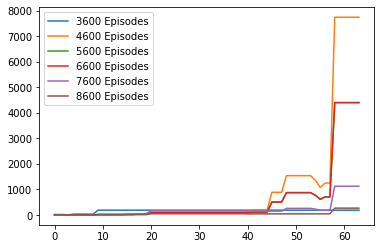

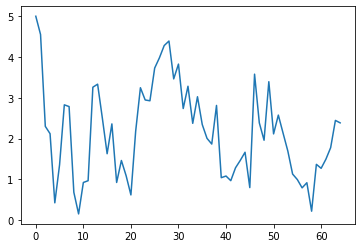

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Activation, multiply
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from collections import deque
from tqdm import tqdm

TEST_EPISODE_LENGTH = 64

class TestEnv:
    def __init__(self):
        self.VALUES = [5]
        value = 5
        for i in range(TEST_EPISODE_LENGTH):
            value = abs(value + np.random.randn())
            self.VALUES.append(value)
    
    def reset(self):
        self.player = Trader()
        self.player.decay_value = 1
        self.episode_step = 0

        self.observations = np.ones(shape=(1, 4)) * self.VALUES[self.episode_step]
        self.currVal = self.VALUES[self.episode_step]
        return self.observations
    
    def step(self, action):
        self.episode_step += 1
        self.player.action(action, self.currVal)

        self.currVal = self.VALUES[self.episode_step]

        self.observations = np.insert(self.observations, self.observations.size, self.currVal, 1)
        self.observations = np.delete(self.observations, 0, axis=1)

        done = False
        if self.check_done():
            done = True

        return self.observations, self.calculate_reward(), done

    def calculate_reward(self):
        return self.player.cash + (self.player.units * self.currVal)

    def check_done(self):
        return self.episode_step > TEST_EPISODE_LENGTH-1 or self.player.broke(self.currVal)

    
results = {}
test_env = TestEnv()

#see efficacy on test data
for i in tqdm(range(6)):
    test_agent = DQNAgent("X", MODEL_LOAD_PATH='models/' + str(i + 3) + '600-model.h5')
    current_state_TEST = test_env.reset()

    rewards_TEST = []

    done_TEST = False
    while not done_TEST:
        action_TEST = np.argmax(test_agent.get_qs(current_state_TEST))
        new_state_TEST, reward_TEST, done_TEST = test_env.step(action_TEST)
        current_state_TEST = new_state_TEST
        rewards_TEST.append([reward_TEST, action_TEST])

    results.update( {str(i + 3)+ "600 Episodes" : rewards_TEST} )

for key, value in results.items():
    reward, choice = zip(*value)
    plt.plot(reward, label=key)

plt.legend()
plt.show()

plt.plot(test_env.VALUES)

Same results graphed a bit more neatly below:

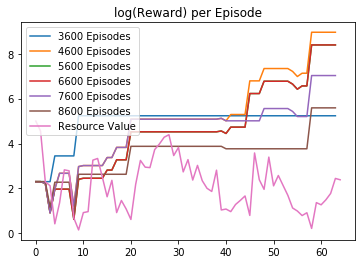

In [0]:
for key, value in results.items():
    reward, choice = zip(*value)
    plt.plot(np.log(reward), label=key)

plt.plot(test_env.VALUES, label = 'Resource Value')
plt.title("log(Reward) per Episode")
plt.legend()
plt.show()

          0  choice
0  5.000000       1
1  4.552186       1
2  2.300682       1
3  2.120756       0
4  0.426159       0


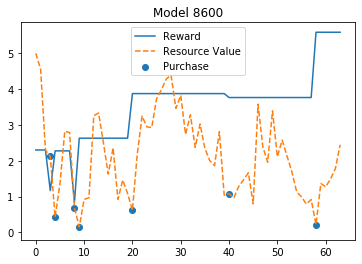

In [0]:
import pandas as pd

data = results["8600 Episodes"]
reward, choice = zip(*value)

x = [i for i in range(len(choice))]
data = pd.DataFrame(test_env.VALUES[:-1])
data['choice'] = choice
sale_points = data[data['choice'] == 0]
print(data.head())

plt.plot(np.log(reward), label="Reward")
plt.plot(test_env.VALUES[:-1], linestyle='dashed', label = 'Resource Value')
plt.scatter(x = sale_points.index, y = sale_points[0], label="Purchase")

plt.title("Model 8600")
plt.legend()

Here the model demonstrates that it takes advantage of 'crashes' in the value. Although, at every point where a purchase is not indicated the agent it trying to sell all of its units so it is not gaining maximum profit (and even suffers a loss around episode 40 where the value drops after the purchase.

##### BUT:
If we change the environment slightly - we see a glaring problem...

In [0]:
TEST_EPISODE_LENGTH = 64

class TestEnv:
    def __init__(self):
        self.VALUES = [5]
        value = 5
        for i in range(TEST_EPISODE_LENGTH):
            value = abs(value + (value/5) * np.random.randn())
            self.VALUES.append(value)
    
    def reset(self):
        self.player = Trader()
        self.player.decay_value = 1
        self.episode_step = 0

        self.observations = np.ones(shape=(1, 4)) * self.VALUES[self.episode_step]
        self.currVal = self.VALUES[self.episode_step]
        return self.observations
    
    def step(self, action):
        self.episode_step += 1
        self.player.action(action, self.currVal)

        self.currVal = self.VALUES[self.episode_step]

        self.observations = np.insert(self.observations, self.observations.size, self.currVal, 1)
        self.observations = np.delete(self.observations, 0, axis=1)

        done = False
        if self.check_done():
            done = True

        return self.observations, self.calculate_reward(), done

    def calculate_reward(self):
        return self.player.cash + (self.player.units * self.currVal)

    def check_done(self):
        return self.episode_step > TEST_EPISODE_LENGTH-1 or self.player.broke(self.currVal)

    
results = {}
test_env = TestEnv()

test_agent = DQNAgent("X", MODEL_LOAD_PATH='models/8600-model.h5')
current_state_TEST = test_env.reset()

rewards_TEST = []

done_TEST = False
while not done_TEST:
    action_TEST = np.argmax(test_agent.get_qs(current_state_TEST))
    new_state_TEST, reward_TEST, done_TEST = test_env.step(action_TEST)
    current_state_TEST = new_state_TEST
    rewards_TEST.append([reward_TEST, action_TEST])

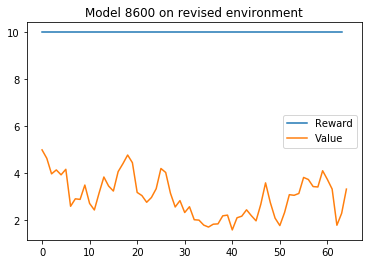

In [0]:
reward, choice = zip(*rewards_TEST)
plt.plot(reward, label="Reward")
plt.title("Model 8600 on revised environment")
plt.plot(test_env.VALUES, label ="Value")
plt.legend()

### Nothing happens?
The above chart shows the reward remain constant as the agent chooses not to buy and sell any units. I have run this 20+ times and receive similar results (except when the value is greater than the agent's cash and the episode ends).

In the environment I changed how the next value is decided - instead of adding a random value from the normal distribution (-1, 1), I made that value proportional to the current value ```(value/5) * np.random.randn()```.

### Conclusion
I believe this proves the agent had found and was exploiting a flaw in my environment design. It would wait until the value dropped to ```< 1.0``` then purchase units - as the next value defined by ```abs(value + np.random.randn())``` was extremely likely to be higher, thus turning a profit. When the agent was able to take advantage of this the rewards would be orders of magnitude higher than fairly gained rewards so the loss function was unable to actually confer any valuable learning.